In [1]:
# Project imports #
import pandas as pd
import numpy as np
import psycopg2 as pg2
import matplotlib.pyplot as plt
import json
import csv
import re
from statsmodels.tsa.seasonal import STL
import statsmodels.api as sm
from datetime import datetime
import calendar
from calendar import monthrange
# Matplotlib settings #
%matplotlib inline
plt.style.use('seaborn')
%config InlineBackend.figure_format = 'svg'

# Extension of Project - Extension 1
#### Objective: To see how local labor demand has changed based on the jobads available on platsbanken between 2006-2020

#### Project outline
- Step 1: Converting JSON files to CSV and extracting relevant data (+data cleaning).
- Step 2: Inserting data into a PostgreSQL database and setting up a query.
- Step 3: Visualization and discussion of results.
- Concluding remarks

### Step 1: Converting JSON files to CSV and extracting relevant data (+data cleaning)
#### All job ads data used in this project is from [JobTechDev](https://jobtechdev.se/en/docs/apis/historical/), an initiative by the Swedish public employment service.

- Variables to be extracted for this project are the following:
    - **headline**: The ad headline.
    - **number_of_vacancies**: The number of advertised jobs for a given ad, a majority only advertise 1 job (5M out of 6.4M ads).
    - **publication_date**: Date the ad was published on Platsbanken, the job ad platform.
    - **application_deadline**: The last date to apply for the job.
    - **last_publication_date**: The last date the ad was public, used as substitutet for application_deadline for 2017 where application_deadline is missing.
    - **municipality_code**: The unique code associated with each municipality in Sweden

In [9]:
total_valid = 0; total_errors = 0
for file in range(2006,2021):
    with open(f'/Users/Kevin/Desktop/project_dta/json_pb2006_2020/{file}.json') as f:
        ads = json.load(f)
        file_ads = []
        error_rows = 0
        
    # For 2017 application_deadline is null, last_publication_date used as a proxy, vars 99.8% equivalent #
    for ad in ads:
        # Removal of special characters using regex, events of \n causes errors in csv file #
        head_line = re.sub('[!,*)@#%(&$_?.^\\\\\n/]', '', str(ad['headline']))
        if file != 2017:
            try: 
        # Slicing of date variables is to ensure only dates of the format 'yyyy-mm-dd' are included, no time data needed #
                ad_select = [head_line, int(ad['number_of_vacancies']), ad['publication_date'][:10], ad['application_deadline'][:10], ad['workplace_address']['municipality_code']]
            except:
                error_rows += 1
                continue
        else:
            try:
                ad_select = [head_line, int(ad['number_of_vacancies']), ad['publication_date'][:10], ad['last_publication_date'][:10], ad['workplace_address']['municipality_code']]
            except:
                error_rows += 1
                continue
                
        # Jobs ads with no vacancies (=0) or missing values (None) in dates or vacancies are removed using all() #
        if all(ad_select[1:]) and 'ALLA' not in ad_select:
            file_ads.append(ad_select)
        else:
            error_rows += 1
            continue
    # We write the extracted data to a csv file for easy insertion into PostgreSQL #             
    with open(f'/Users/Kevin/Desktop/project_dta/csv_pd2006_2020_city/{file}_municode.csv', mode='w', newline="") as file_writer:
        write = csv.writer(file_writer)
        for row in file_ads:
            write.writerow(row)
    print(f'valid ads for {file}: ' + str(len(file_ads)), ' | ', f'erroneous ads for {file}: ' + str(error_rows))
    total_valid += len(file_ads); total_errors += error_rows
print('\n')
print('total valid ads: ' + str(total_valid), '  |  ', 'total erroneous ads: '+ str(total_errors))

valid ads for 2006: 209153  |  erroneous ads for 2006: 36074
valid ads for 2007: 259423  |  erroneous ads for 2007: 24682
valid ads for 2008: 240130  |  erroneous ads for 2008: 25093
valid ads for 2009: 174451  |  erroneous ads for 2009: 21673
valid ads for 2010: 263165  |  erroneous ads for 2010: 26089
valid ads for 2011: 335272  |  erroneous ads for 2011: 29416
valid ads for 2012: 346145  |  erroneous ads for 2012: 33213
valid ads for 2013: 355452  |  erroneous ads for 2013: 34601
valid ads for 2014: 419379  |  erroneous ads for 2014: 32606
valid ads for 2015: 583994  |  erroneous ads for 2015: 29519
valid ads for 2016: 693570  |  erroneous ads for 2016: 24476
valid ads for 2017: 694039  |  erroneous ads for 2017: 21252
valid ads for 2018: 659482  |  erroneous ads for 2018: 23487
valid ads for 2019: 514672  |  erroneous ads for 2019: 125585
valid ads for 2020: 449857  |  erroneous ads for 2020: 40856


total valid ads: 6198184   |   total erroneous ads: 528622


- More rows are filtered out now that restrictions are harder. Now, if the municipality code is NULL, row is discarded

### Step 2: Inserting data into a postgreSQL database and setting up relevant query
 - For efficient analysis and storage of the dataset we import the data into PostgreSQL.

In [52]:
# DB created in pgAdmin4 GUI, login and connect cursor #
conn = pg2.connect(database='job_ads', user='postgres', password='***********')
cur = conn.cursor()

In [48]:
# Table creation # 
# If data cleaning method in previous step missed any invalid ads, NOT NULL ascertains that no invalid ads are included #
cur.execute("""
CREATE TABLE historic_ads_muni(
    ad_id SERIAL PRIMARY KEY,
    headline VARCHAR,
    number_of_vacancies INTEGER NOT NULL,
    publication_date DATE NOT NULL,
    application_deadline DATE NOT NULL,
    municipality_code INTEGER NOT NULL)
    ;""")
conn.commit()

In [49]:
# Load in keys for join #
cur.execute("""
CREATE TABLE municipality_codes(
    groups VARCHAR NOT NULL,
    municipality_code INTEGER NOT NULL,
    municipality_name VARCHAR NOT NULL,
    main_group_code VARCHAR NOT NULL,
    main_group_name VARCHAR NOT NULL,
    municipality_group_code INTEGER NOT NULL,
    municipality_group_name VARCHAR NOT NULL,
    county_code INTEGER NOT NULL,
    county_name VARCHAR NOT NULL)
    ;""")
conn.commit()

In [50]:
# Importing csv files into PostgreSQL #
for file in range(2006, 2021):
    with open(f'/Users/Kevin/Desktop/project_dta/csv_pd2006_2020_muni_int/{file}_municode.csv', 'r') as csv_file:
        cur.copy_from(csv_file, 'historic_ads_muni', sep=',', columns=('headline', 'number_of_vacancies', 'publication_date', 'application_deadline', 'municipality_code'))
    conn.commit()
# Importin keys for 
with open('/Users/Kevin/Desktop/project_dta/csv_pd2006_2020_muni_int/municipality_codes_int', 'r') as csv_file:
    cur.copy_from(csv_file, 'municipality_codes', sep=',', columns=('groups', 'municipality_code', 'municipality_name', 'main_group_code', 'main_group_name', 'municipality_group_code', 'municipality_group_name', 'county_code', 'county_name'))
    conn.commit()

In [54]:
# Full inner join #
cur.execute("""
    CREATE TABLE historic_ads_extension_1 AS 
    (SELECT ad_id, headline, number_of_vacancies, publication_date, application_deadline, historic_ads_muni.municipality_code, municipality_codes.municipality_name, municipality_codes.municipality_group_code, municipality_codes.municipality_group_name, municipality_codes.county_code, municipality_codes.county_name
    FROM historic_ads_muni
    INNER JOIN municipality_codes
    ON historic_ads_muni.municipality_code = municipality_codes.municipality_code);
    ;""")
conn.commit()

- In the cell below we check, for each day between 2006-2020, how many ads were active for a given day and sum the vacancies of these ads. This is done by looping through each day in the time interval and checking how many ads have the given day (e.g. 2006-05-22) in between it's publication and deadline date (e.g. pub 2006-04-27 --  dead 2006-05-23). For all active ads, vacancies are summed and appended to a list as results.

In [95]:
# Analysis of labor demand by city size #
vacancies_per_day = []
vacancies_per_day.append(["Date", "Rural Municipality", "Rural municipality with hospitality industry", "Low commuting municipality near major city"
, "Small town/urban area", "Commuting municipality near smaller urban area", "Commuting municipality near big city", "Commuting municipality near major city"
,"Metropolitan areas", "Big cities"])

for year in range(2006, 2021):
    for month in range(1,13):
        # We have to skip first month since some groups have values of zero #
        if year == 2006 and month == 1:
            continue
        for day in range(1, calendar.monthrange(year, month)[1] + 1):
            cur.execute(f"""
            SELECT SUM(number_of_vacancies), municipality_group_name FROM historic_ads_extension_1 
            WHERE '{year}-{month}-{day}' >= publication_date AND '{year}-{month}-{day}' <= application_deadline
            GROUP BY municipality_group_name;""")
            muni_ads = cur.fetchall()
            vacancies_per_day.append([f'{year}-{month}-{day}', muni_ads[0][0], muni_ads[1][0], muni_ads[2][0], muni_ads[3][0],
                                       muni_ads[4][0], muni_ads[5][0],muni_ads[6][0],muni_ads[7][0],muni_ads[8][0]])

# We save the results to a csv file #
with open(f'/Users/Kevin/Desktop/project_dta/csv_pd2006_2020_muni_int/results.csv', mode='w', newline="") as file_writer:
    write = csv.writer(file_writer)
    for row in vacancies_per_day:
        write.writerow(row) 

### Step 3: Visualization and discussion of results
#### The comparison data from Statistics Sweden and can be found [here](https://www.statistikdatabasen.scb.se/pxweb/en/ssd/START__AM__AM0701__AM0701A/KVLedigajobbSektor/).
- The comparison data is based on survey results that are published quarterly by Sweden's statistical agency, Statistics Sweden (SCB).
- The selected comparison data is between Q1 2006 - Q3 2020 which coincides with our job ads data.

In [6]:
# Importing  csv files and adding appropriate datetime indexing #
muni_results = pd.read_csv('/Users/Kevin/Desktop/project_dta/csv_pd2006_2020_muni_int/results.csv')
muni_results = muni_results.set_index(pd.to_datetime(muni_results['Date'])).drop('Date', axis=1)

In [7]:
# Creating range and labels for plot x-axis #
date_index = pd.date_range('2006','2022', freq='Y')
date_index = date_index.values.astype('datetime64[Y]')
date_range = np.arange(2006, 2022)

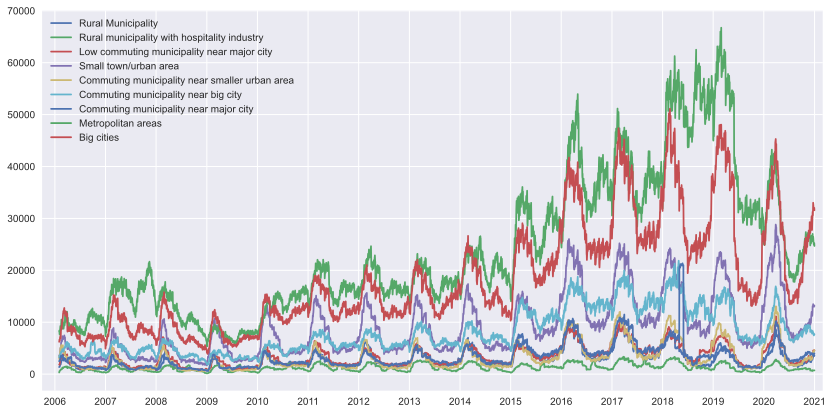

In [8]:
fig = plt.figure(figsize=(14,7))

for cols in range(len(muni_results.columns)):
    plt.plot(muni_results.index, muni_results.iloc[:,cols], label=muni_results.columns[cols])

plt.xticks(ticks=date_index, labels=date_range)
plt.xlim(datetime(2005,10,1), datetime(2021,3,1))
plt.legend()
plt.show()

### Discussion
- In progress

### Concluding remarks
#### Thank you for examining my project! Pleas contact me if you have any feedback on possible improvement or other comments on the project.

Contact: [kevin.dee.boman@gmail.com](kevin.dee.boman@gmail.com)

#### Future project plans:

   - In a future project, a current labor demand index will be constructed using JobTechDevs API service in combination with ads scraped from supplementary sources that systematically are not posted on platsbanken (The public employment service job ads platform).
   - The index may also be disaggregated by county/city and occupational group using [SSYK classification](https://www.scb.se/dokumentation/klassifikationer-och-standarder/standard-for-svensk-yrkesklassificering-ssyk/) (Swedens official classification system for occupational groups, only available in Swedish). This would extend the use of the index as regional labor demand and labor demand among different occupational groups could be estimated.